### Generate CSV with attack data

In [42]:
import numpy as np
import csv
from random import randint

def dmgCalc(AB, AC, critrange, critmult, critconfirmbonus, multdmg, nonmultdmg):
    roll = randint(1,20)
    atkroll = AB + roll

    if ((atkroll >= AC) or (roll == 20)) and (roll != 1): #hit

        rolledmultdmg = 0
        for _ in range(multdmg["numberofdice"]):
            rolledmultdmg += randint(1,multdmg["sizeofdice"])
        rolledmultdmg += multdmg["dmgbonus"]

        rollednonmultdmg = 0
        for _ in range(nonmultdmg["numberofdice"]):
            rollednonmultdmg += randint(1,nonmultdmg["sizeofdice"])
        rollednonmultdmg += nonmultdmg["dmgbonus"]

        if (roll >= critrange): #crit threat
            critconfirmroll = AB+critconfirmbonus+randint(1,20)

            if (critconfirmroll >= AC): #crit confirmed
                dmg = rolledmultdmg*critmult + rollednonmultdmg
            else: #crit not confirmed
                dmg = rolledmultdmg + rollednonmultdmg

        else: #regular hit
            dmg = rolledmultdmg + rollednonmultdmg

    else: #miss
        dmg = 0

    return dmg

def getstats(AB, AC, critrange, critmult, critconfirmbonus, multdmg, nonmultdmg, iterations):
    result = []
    for _ in range(iterations):
        result.append(dmgCalc(AB, AC, critrange, critmult, critconfirmbonus, multdmg, nonmultdmg))
    avg = np.mean(result)
    std = np.std(result)
    return avg, std


DATASIZE = 1000
ITERATIONS = 10000

f = open('dmgdata.csv', 'w', newline='')
writer = csv.writer(f)
header = ['AB-AC', 'Crit Range', 'Crit Mult', 'Crit Confirm Bonus', 'Mult Dmg', 'Non Mult Dmg', 'Mean', 'Standard Deviation']
writer.writerow(header)

for i in range(DATASIZE):
    AB = randint(-10,100)
    AC = randint(0,100)
    critrange = randint(16,20)
    critmult = randint(1,4)
    critconfirmbonus = randint(0,3)
    multdmg = {"numberofdice": randint(0,12), "sizeofdice": randint(4,12), "dmgbonus": randint(-5,200)}
    nonmultdmg = {"numberofdice": randint(0,12), "sizeofdice": randint(4,8), "dmgbonus": randint(0,50)}

    avg, std = getstats(AB, AC, critrange, critmult, critconfirmbonus, multdmg, nonmultdmg, ITERATIONS)

    row = [AB-AC, critrange, critmult, critconfirmbonus, multdmg["numberofdice"] * ((multdmg["sizeofdice"]+1)/2) + multdmg["dmgbonus"], nonmultdmg["numberofdice"] * ((nonmultdmg["sizeofdice"]+1)/2) + nonmultdmg["dmgbonus"], avg, std ]

    writer.writerow(row)

    print(i+1, '/', DATASIZE, end="\r")

f.close()

### ML implementation

In [46]:
import pandas as pd
from sklearn import linear_model


data=pd.read_csv("dmgdata.csv")

data_in = data.loc[:,'AB-AC':'Non Mult Dmg']
data_target_mean = data.loc[:,'Mean']
data_target_std = data.loc[:,'Standard Deviation']


#normalization
data_in_norm=(data_in-data_in.mean(numeric_only=True))/data_in.std(numeric_only=True)

data_in_norm_train = data_in_norm.iloc[:800,:]
data_in_norm_test = data_in_norm.iloc[800:,:]

data_target_mean_train = data_target_mean.iloc[:800]
data_target_mean_test = data_target_mean.iloc[800:]

data_target_std_train = data_target_std.iloc[:800]
data_target_std_test = data_target_std.iloc[800:]

data_target = data.loc[:,'Mean':'Standard Deviation']
data_target_train = data_target.iloc[:800]
data_target_test = data_target.iloc[800:]


#ridge regression
λ = 0

regr = linear_model.Ridge(alpha=λ)

regr.fit(data_in_norm_train.to_numpy(), data_target_mean_train.to_numpy())

print("R^2 Score: ", regr.score(data_in_norm_test.to_numpy(), data_target_mean_test.to_numpy()))
print("Intercept: ", regr.intercept_)
print("Coefficients: ", regr.coef_)

R^2 Score:  0.6958223470639027
Intercept:  111.17150455875202
Coefficients:  [71.47979007 -9.28634269  7.74281181 -3.78991443 44.11329355 10.51504414]


### Deu ruim
:(


### Again!

In [47]:
from sklearn.neural_network import MLPRegressor

clf = MLPRegressor(max_iter=100000, random_state=9, hidden_layer_sizes=(100,100), activation='relu', alpha=0, learning_rate='adaptive', tol=1e-6 )

clf.fit(data_in_norm_train.to_numpy(), data_target_train.to_numpy())

print("Score: ", clf.score(data_in_norm_test.to_numpy(), data_target_test.to_numpy()))

Score:  0.9950706431789003


In [48]:
NNres = clf.predict(data_in_norm_test.to_numpy())

In [58]:
import numpy as np

AB = 48
AC = 50
critrange = 18
critmult = 4
critconfirmbonus = 1
multdmg = {"numberofdice": 3, "sizeofdice": 6, "dmgbonus": 62}
nonmultdmg = {"numberofdice": 5, "sizeofdice": 4, "dmgbonus": 2}

AB_AC = AB-AC
multdmg = multdmg["numberofdice"]*(multdmg["sizeofdice"]+1)/2 + multdmg["dmgbonus"]
nonmultdmg = nonmultdmg["numberofdice"]*(nonmultdmg["sizeofdice"]+1)/2 + nonmultdmg["dmgbonus"]

a = np.asarray([AB_AC, critrange, critmult, critconfirmbonus, multdmg, nonmultdmg])
a = (a-np.mean(data_in.to_numpy()))/np.std(data_in.to_numpy())
a = a.reshape(1, -1)


print(clf.predict(a))

[[ 9.44275095 46.02460131]]


### Analylical Approach 

In [1]:
def dmgCalc(AB, AC, critrange, critmult, critconfirmbonus, multdmg, nonmultdmg):
    roll = randint(1,20)
    atkroll = AB + roll

    if ((atkroll >= AC) or (roll == 20)) and (roll != 1): #hit

        rolledmultdmg = 0
        for _ in range(multdmg["numberofdice"]):
            rolledmultdmg += randint(1,multdmg["sizeofdice"])
        rolledmultdmg += multdmg["dmgbonus"]

        rollednonmultdmg = 0
        for _ in range(nonmultdmg["numberofdice"]):
            rollednonmultdmg += randint(1,nonmultdmg["sizeofdice"])
        rollednonmultdmg += nonmultdmg["dmgbonus"]

        if (roll >= critrange): #crit threat
            critconfirmroll = randint(1,20)
            critconfirmatkroll = AB+critconfirmbonus+critconfirmroll

            if ((critconfirmatkroll >= AC) and (critconfirmroll != 1)) or (critconfirmroll == 20): #crit confirmed
                dmg = rolledmultdmg*critmult + rollednonmultdmg
            else: #crit not confirmed
                dmg = rolledmultdmg + rollednonmultdmg

        else: #regular hit
            dmg = rolledmultdmg + rollednonmultdmg

    else: #miss
        dmg = 0

    return dmg

In [2]:
import numpy as np

In [60]:
AB = 48
AC = 50
critrange = 18
critmult = 4
critconfirmbonus = 1
multdmg = {"numberofdice": 3, "sizeofdice": 6, "dmgbonus": 62}
nonmultdmg = {"numberofdice": 5, "sizeofdice": 4, "dmgbonus": 2}

critfailchance = 1 / 20
misschance = max( [ min((AC-AB-2), 18), 0 ] ) / 20
normalhitchance = max( [ min((21-(AC-AB)), 19) - (21-critrange), 0 ] ) / 20
critconfirmfailchance = ( min((20-critrange), max(critrange-(AC-AB-2), 0)) / 20) * (min(max(((AC-(AB+critconfirmbonus))-1), 1), 19) / 20) 
critconfirmsuccchance = (min((20-critrange), max(critrange-(AC-AB-2), 0)) / 20) * (max(min((21-(AC-(AB+critconfirmbonus))), 19), 1) / 20)
nat20failchance = (1 / 20) * (min(max(((AC-(AB+critconfirmbonus))-1), 1), 19) / 20)  
nat20succchance = (1 / 20) * (max(min((21-(AC-(AB+critconfirmbonus))), 19), 1) / 20)

Propriedades das distruibuições:\
https://eng.libretexts.org/Bookshelves/Computer_Science/Programming_and_Computation_Fundamentals/Mathematics_for_Computer_Science_(Lehman_Leighton_and_Meyer)/04%3A_Probability/19%3A_Deviation_from_the_Mean/19.03%3A_Properties_of_Variance\
https://proofwiki.org/wiki/Variance_of_Discrete_Uniform_Distribution\
https://stats.stackexchange.com/questions/16608/what-is-the-variance-of-the-weighted-mixture-of-two-gaussians

In [61]:
probzero = critfailchance+misschance
probnormaldmg = normalhitchance+critconfirmfailchance+nat20failchance
probcritdmg = critconfirmsuccchance+nat20succchance



normaldmgmean = (multdmg["numberofdice"] * ((multdmg["sizeofdice"]+1)/2) + multdmg["dmgbonus"]) + (nonmultdmg["numberofdice"] * ((nonmultdmg["sizeofdice"]+1)/2) + nonmultdmg["dmgbonus"])
critdmgmean = critmult*(multdmg["numberofdice"] * ((multdmg["sizeofdice"]+1)/2) + multdmg["dmgbonus"]) + (nonmultdmg["numberofdice"] * ((nonmultdmg["sizeofdice"]+1)/2) + nonmultdmg["dmgbonus"])

totaldmgmean = (probzero * 0) + (probnormaldmg * normaldmgmean) + (probcritdmg * critdmgmean)




multdicevar = ((multdmg["sizeofdice"]**2)-1)/12
nonmultdicevar = ((nonmultdmg["sizeofdice"]**2)-1)/12

normaldmgvar = ((multdmg["numberofdice"]**2)*multdicevar) + ((nonmultdmg["numberofdice"]**2)*nonmultdicevar)
critdmgvar = ( (critmult**2) * (multdmg["numberofdice"]**2) * multdicevar ) + ((nonmultdmg["numberofdice"]**2)*nonmultdicevar)


totaldmgvar = probzero*0 + probnormaldmg*normaldmgvar + probcritdmg*critdmgvar + ((probzero*(0**2) + probnormaldmg*(normaldmgmean**2) + probcritdmg*(critdmgmean**2)) - (totaldmgmean**2))

print("mean: ", totaldmgmean)
print("std: ", np.sqrt(totaldmgvar))




mean:  113.64375000000001
std:  80.74921415058786


In [13]:
from random import randint, random

IT = 1000000
dmgs = []
for _ in range(IT):
    if random() >= misschancestat:
        dmgs.append(dmgCalc(AB, AC, critrange, critmult, critconfirmbonus, multdmg, nonmultdmg))
    else:
        dmgs.append(0)

print("mean: ", np.mean(dmgs))
print("std: ", np.std(dmgs))



mean:  113.678424
std:  80.30946547497517


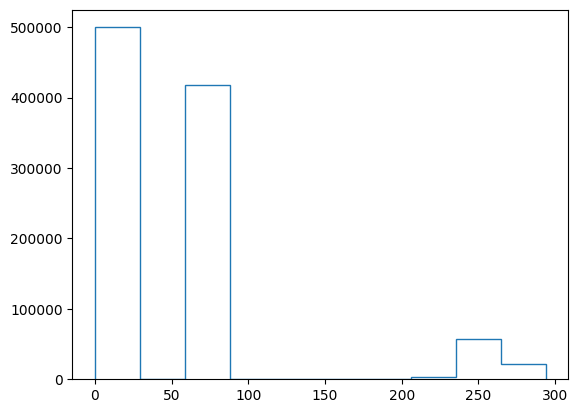

In [62]:
import matplotlib.pyplot as plt

counts, bins = np.histogram(dmgs)
plt.stairs(counts, bins)